EXP 5 : (H and E) vs S

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.4 MB/s eta 0:00:00


Without optimiser

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5858 - loss: 98.5312 - val_accuracy: 0.7000 - val_loss: 4.4417
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7021 - loss: 8.1779 - val_accuracy: 0.6889 - val_loss: 4.0883
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7752 - loss: 2.9302 - val_accuracy: 0.7111 - val_loss: 2.4043
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8040 - loss: 1.6730 - val_accuracy: 0.6667 - val_loss: 2.9774
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8189 - loss: 1.4393 - val_accuracy: 0.8667 - val_loss: 0.5470
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9110 - loss: 0.3291 - val_accuracy: 0.8000 - val_loss: 0.8263
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9203 - loss: 0.2745 - val_accuracy: 0.7000 - val_loss: 1.2586
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9234 - loss: 0.2214 - val_accuracy: 0.8444 - val_loss: 0.3986
Epoch 9/30

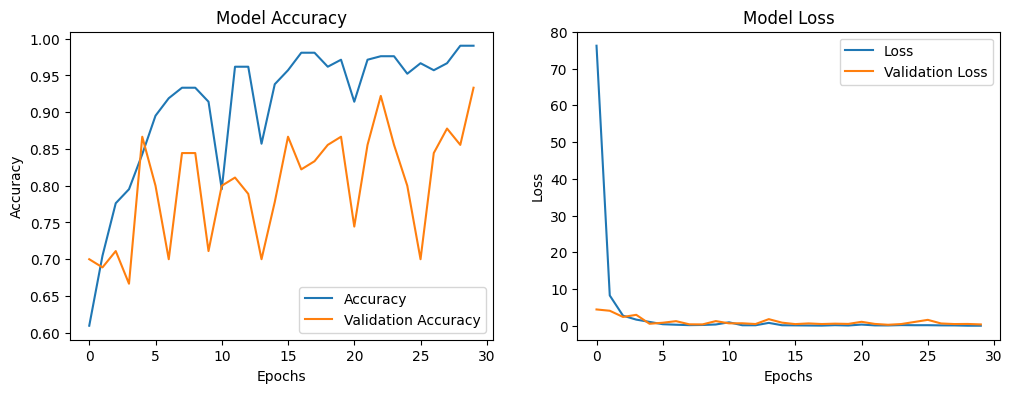

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp5/No_Options.keras ✅


In [ ]:
# Import necessary libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import pywt
import time  # For tracking training time

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function to apply wavelet transform (Level 5 Daubechies 4)
def wavelet_transform(data, level=5):
    transformed_data = []
    for signal in data:
        coeffs = pywt.wavedec(signal, 'db4', level=level)
        # Only use the approximation (low-frequency) coefficients for simplicity
        approximation = coeffs[0]
        transformed_data.append(approximation)
    return np.array(transformed_data)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Healthy
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # Epileptic
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizure

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (label 0)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (label 1)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=1)  # Seizure (label 1)

# Combine data and labels for Healthy and Epileptic vs Seizure
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Modify labels: Healthy and Epileptic are 0, Seizure is 1
    labels_all = np.where(labels_all == 1, 1, 0)  # Seizure (1) vs Healthy and Epileptic (0)

    # Apply wavelet transform to the data (Level 5 Daubechies 4)
    data_all_wavelet = wavelet_transform(data_all)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all_wavelet, labels_all, test_size=0.3, random_state=42)

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for Healthy + Epileptic, 1 for Seizure)
    ])

    # Compile the model without optimizer (no optimizer)
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])

    # Record training start time
    start_time = time.time()

    # Train the model
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)

    # Record training end time
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Time: {:.2f} seconds".format(training_time))

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")

     # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp5/No_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")




With Standerscaler

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 493ms/step - accuracy: 0.5359 - loss: 1.5705 - val_accuracy: 0.6000 - val_loss: 0.5254
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 760ms/step - accuracy: 0.7183 - loss: 0.4550 - val_accuracy: 0.6000 - val_loss: 0.5854
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 507ms/step - accuracy: 0.7840 - loss: 0.4148 - val_accuracy: 0.6778 - val_loss: 0.4988
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 399ms/step - accuracy: 0.8344 - loss: 0.3371 - val_accuracy: 0.8222 - val_loss: 0.4035
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 510ms/step - accuracy: 0.6928 - loss: 0.5510 - val_accuracy: 0.7667 - val_loss: 0.4618
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 525ms/step - accuracy: 0.8877 - loss: 0.3218 - val_accuracy: 0.7778 - val_loss: 0.4512
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 393ms/step - accuracy: 0.9062 - loss: 0.2690 - val_accuracy: 0.7000 - val_loss: 0.5505
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 660ms/step - accuracy: 0.9090 - loss: 0.2580 - val_accuracy: 0.8222 - val_loss:

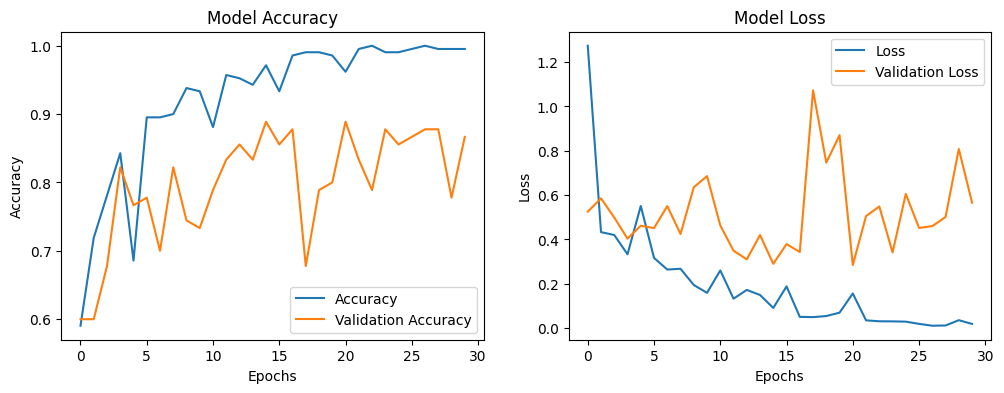

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp5/With_Stander.keras ✅


In [ ]:
# Import necessary libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import pywt
import time  # For timing the training process

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function for Wavelet Transform (db4 at level 5)
def apply_wavelet_transform(data, wavelet='db4', level=5):
    transformed_data = []
    for signal in data:
        # Apply wavelet transform (db4) at level 5
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        # Reconstruct the signal using the approximation and detailed coefficients
        reconstructed_signal = pywt.waverec(coeffs, wavelet)
        # Append the transformed signal (truncate to match original size)
        transformed_data.append(reconstructed_signal[:len(signal)])
    return np.array(transformed_data)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Healthy
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # Epileptic
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizure

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (label 0)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (label 1)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=1)  # Seizure (label 1)

# Combine data and labels for Healthy and Epileptic vs Seizure
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Modify labels: Healthy and Epileptic are 0, Seizure is 1
    labels_all = np.where(labels_all == 1, 1, 0)  # Seizure (1) vs Healthy and Epileptic (0)

    # Apply Wavelet Transform (db4 at level 5)
    data_all_wavelet = apply_wavelet_transform(data_all)

    # Standard Scaling (normalize the data after wavelet transform)
    scaler = StandardScaler()
    data_all_wavelet = scaler.fit_transform(data_all_wavelet)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all_wavelet, labels_all, test_size=0.3, random_state=42)

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for Healthy + Epileptic, 1 for Seizure)
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])

    # Start timing the training process
    start_time = time.time()

    # Train the model
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)

    # Calculate the training time
    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")




        # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp5/With_Stander.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")





With Optimiser

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 655ms/step - accuracy: 0.6039 - loss: 227.8363 - val_accuracy: 0.6111 - val_loss: 144.8965
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - accuracy: 0.6641 - loss: 105.2801 - val_accuracy: 0.6222 - val_loss: 10.9436
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 425ms/step - accuracy: 0.6688 - loss: 10.3912 - val_accuracy: 0.6444 - val_loss: 3.1905
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.7385 - loss: 2.2239 - val_accuracy: 0.6444 - val_loss: 2.4502
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 427ms/step - accuracy: 0.7959 - loss: 0.9061 - val_accuracy: 0.7889 - val_loss: 0.7768
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 625ms/step - accuracy: 0.8441 - loss: 0.4561 - val_accuracy: 0.8778 - val_loss: 0.4064
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 472ms/step - accuracy: 0.9250 - loss: 0.2305 - val_accuracy: 0.8333 - val_loss: 0.5466
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 420ms/step - accuracy: 0.9454 - loss: 0.2014 - val_accuracy: 0.9000 - val_loss: 0.

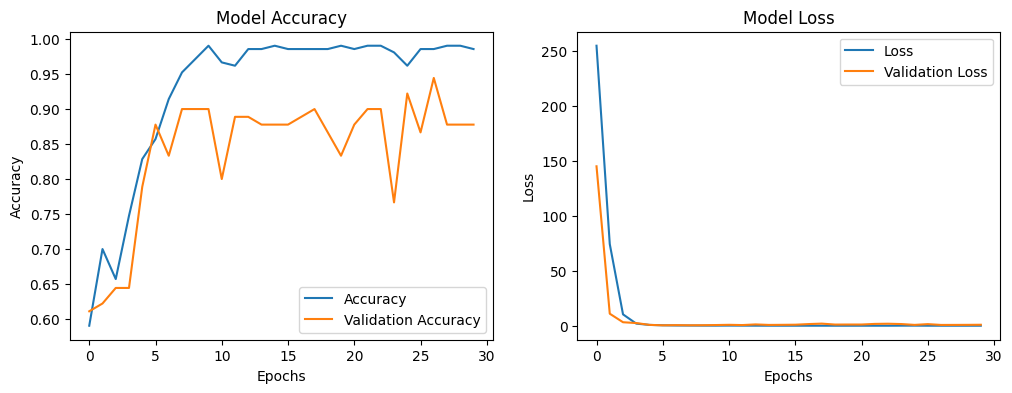

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp5/With_Optimiser.keras ✅


In [ ]:
# Import necessary libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import pywt
import time  # For timing the training process

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function for Wavelet Transform (db4 at level 5)
def apply_wavelet_transform(data, wavelet='db4', level=5):
    transformed_data = []
    for signal in data:
        # Apply wavelet transform (db4) at level 5
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        # Reconstruct the signal using the approximation and detailed coefficients
        reconstructed_signal = pywt.waverec(coeffs, wavelet)
        # Append the transformed signal (truncate to match original size)
        transformed_data.append(reconstructed_signal[:len(signal)])
    return np.array(transformed_data)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Healthy
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # Epileptic
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizure

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (label 0)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (label 1)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=1)  # Seizure (label 1)

# Combine data and labels for Healthy and Epileptic vs Seizure
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Modify labels: Healthy and Epileptic are 0, Seizure is 1
    labels_all = np.where(labels_all == 1, 1, 0)  # Seizure (1) vs Healthy and Epileptic (0)

    # Apply Wavelet Transform (db4 at level 5)
    data_all_wavelet = apply_wavelet_transform(data_all)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all_wavelet, labels_all, test_size=0.3, random_state=42)

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for Healthy + Epileptic, 1 for Seizure)
    ])

    # Compile the model with Adam optimizer
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Start timing the training process
    start_time = time.time()

    # Train the model
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)

    # Calculate the training time
    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")



     # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp5/With_Optimiser.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")



with both op and standerscaler

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 507ms/step - accuracy: 0.7188 - loss: 1.8467 - val_accuracy: 0.6111 - val_loss: 0.5499
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step - accuracy: 0.6988 - loss: 0.4900 - val_accuracy: 0.6111 - val_loss: 0.5413
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - accuracy: 0.7000 - loss: 0.5095 - val_accuracy: 0.6111 - val_loss: 0.5149
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 410ms/step - accuracy: 0.6928 - loss: 0.4570 - val_accuracy: 0.6111 - val_loss: 0.5351
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 384ms/step - accuracy: 0.6991 - loss: 0.4211 - val_accuracy: 0.6222 - val_loss: 0.4977
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 573ms/step - accuracy: 0.7809 - loss: 0.4094 - val_accuracy: 0.6778 - val_loss: 0.4926
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 400ms/step - accuracy: 0.7801 - loss: 0.3895 - val_accuracy: 0.6667 - val_loss: 0.4995
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 433ms/step - accuracy: 0.8240 - loss: 0.3585 - val_accuracy: 0.7333 - val_loss:

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step

Final Evaluation Metrics:
Test Accuracy:  0.8888888888888888
Test Recall (Sensitivity):  0.9818181818181818
Test Precision:  0.8571428571428571
Test Specificity:  0.7428571428571429
Confusion Matrix: 
 [[26  9]
 [ 1 54]]


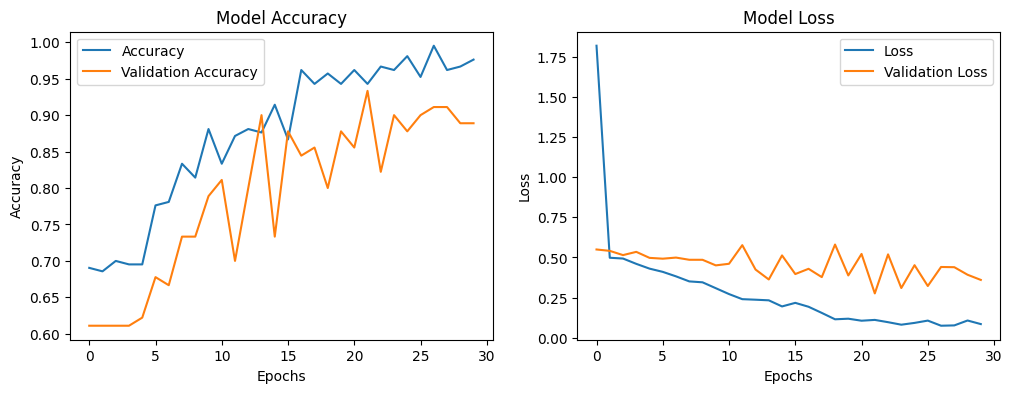

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp5/With_Options.keras ✅


In [ ]:
# Import necessary libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import pywt
import time  # For timing the training process

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function for Wavelet Transform (db4 at level 5)
def apply_wavelet_transform(data, wavelet='db4', level=5):
    transformed_data = []
    for signal in data:
        # Apply wavelet transform (db4) at level 5
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        # Reconstruct the signal using the approximation and detailed coefficients
        reconstructed_signal = pywt.waverec(coeffs, wavelet)
        # Append the transformed signal (truncate to match original size)
        transformed_data.append(reconstructed_signal[:len(signal)])
    return np.array(transformed_data)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Healthy
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # Epileptic
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizure

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (label 0)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (label 1)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=1)  # Seizure (label 1)

# Combine data and labels for Healthy and Epileptic vs Seizure
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Modify labels: Healthy and Epileptic are 0, Seizure is 1
    labels_all = np.where(labels_all == 1, 1, 0)  # Seizure (1) vs Healthy and Epileptic (0)

    # Apply Wavelet Transform (db4 at level 5)
    data_all_wavelet = apply_wavelet_transform(data_all)

    # Standard Scaling (normalize the data after wavelet transform)
    scaler = StandardScaler()
    data_all_wavelet = scaler.fit_transform(data_all_wavelet)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all_wavelet, labels_all, test_size=0.3, random_state=42)

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for Healthy + Epileptic, 1 for Seizure)
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Start timing the training process
    start_time = time.time()

    # Train the model
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)

    # Calculate the training time
    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


      # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp5/With_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


